In [1]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt

%matplotlib inline

In [2]:
import re
pattern = re.compile('\((-?[\d.]+),\s(-?[\d.]+)\)')
def extract_lat_lng_from_string(addr):
    m = (addr and type(addr) is str) and pattern.search(addr) or None
    return m and [float(m.group(1)), float(m.group(2))] or [None, None]

def extract_lat_lng(df, column):
    extracted = pd.DataFrame(
        [extract_lat_lng_from_string(s) for s in df[column]],
        columns=['lat', 'lng'])
    
    extracted.dropna(inplace=True)
    return extracted

In [3]:
# Read in all the data
calls = pd.read_csv("blight/data/detroit-311.csv")
blights = pd.read_csv('blight/data/detroit-blight-violations.csv')
crimes = pd.read_csv('blight/data/detroit-crime.csv')
demos = pd.read_csv('blight/data/detroit-demolition-permits.tsv', delimiter='\t')

/usr/local/lib/python2.7/site-packages/pandas/io/parsers.py:1170: DtypeWarning: Columns (6,10,11,12) have mixed types. Specify dtype option on import or set low_memory=False.
  data = self._reader.read(nrows)
/usr/local/lib/python2.7/site-packages/pandas/io/parsers.py:1170: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  data = self._reader.read(nrows)


In [4]:
# Gather up all lat lon pairs across all the data
locations = {
    'calls': calls[['lat', 'lng']],
    'blights': extract_lat_lng(blights, 'ViolationAddress'),
    'crimes': extract_lat_lng(crimes, 'LOCATION'),
    'demos': extract_lat_lng(demos, 'site_location')
}

all_locations = pd.concat(locations.values(), ignore_index=True)

In [5]:
all_locations.dtypes

lat    float64
lng    float64
dtype: object

In [6]:
print 'Total incident locations: %d' % len(all_locations)
print '311 calls: %d' % len(calls)
print 'Blight violations: %d' % len(blights)
print 'Crimes: %d' % len(crimes)
print 'Demos: %d' % len(demos)

Total incident locations: 453701
311 calls: 19680
Blight violations: 307804
Crimes: 119931
Demos: 7133


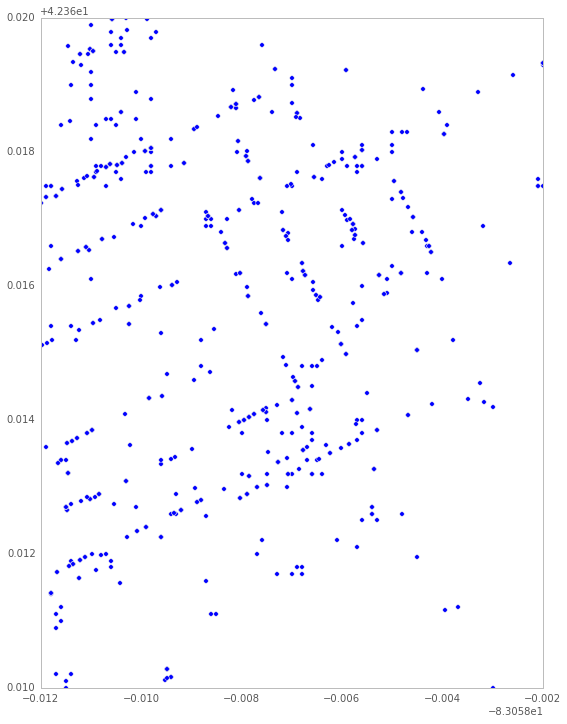

In [78]:
def plot(sample, lat_min, lat_max, lng_min, lng_max):
    plt.figure(figsize=(9,12))
    plt.xlim([lng_min, lng_max])
    plt.ylim([lat_min, lat_max])
    #plt.title("Across all of Detroit")

    loc = all_locations
    plt.scatter(loc['lng'], loc['lat'])

    #bloc = locations['blights']
    #bloc = bloc.sample(int(len(bloc) * sample))
    #plt.scatter(bloc['lng'], bloc['lat'], color='red')

    #cloc = locations['crimes']
    #cloc = cloc.sample(int(len(cloc) * sample))
    #plt.scatter(cloc['lng'], cloc['lat'], color='green')
    
# Plot 1% sample across all of detroit
#plot(0.01, 42.25, 42.46, -83.3, -82.9)

# Plot just a particular area
plot(1, 42.37, 42.38, -83.07, -83.06)

In [124]:
def loc_slice(df, min_lat, max_lat, min_lng, max_lng):
    df = df[df['lng'] > min_lng]
    df = df[df['lng'] < max_lng]
    df = df[df['lat'] > min_lat]
    df = df[df['lat'] < max_lat]
    return df

#sample = loc_slice(locations['crimes'], 42.37, 42.38, -83.07, -83.06)
sample = loc_slice(all_locations, 42.37, 42.38, -83.07, -83.06)

In [129]:
X = sample.as_matrix()
#X = all_locations.as_matrix()
#X = StandardScaler().fit_transform(X)

In [126]:
len(X)

766

In [130]:
from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.datasets.samples_generator import make_blobs
from sklearn.preprocessing import StandardScaler

# Compute DBSCAN
db = DBSCAN(eps=0.0001, min_samples=1).fit(X)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)

print('Estimated number of clusters: %d' % n_clusters_)

Estimated number of clusters: 324


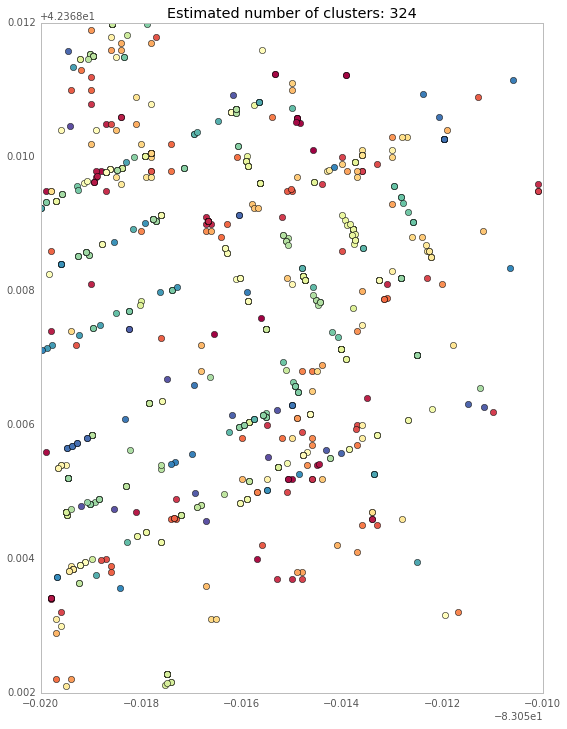

In [131]:
unique_labels = set(labels)
colors = plt.cm.Spectral(np.linspace(0, 1, len(unique_labels)))
plt.figure(figsize=(9,12))
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = 'k'

    class_member_mask = (labels == k)

    xy = X[class_member_mask & core_samples_mask]
    plt.plot(xy[:, 1], xy[:, 0], 'o', markerfacecolor=col,
             markeredgecolor='k')#, markersize=14)

    xy = X[class_member_mask & ~core_samples_mask]
    plt.plot(xy[:, 1], xy[:, 0], 'o', markerfacecolor=col,
             markeredgecolor='k')#, markersize=6)

plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.show()

In [149]:
buildings = pd.DataFrame({
        'building_id': db.labels_,
        'lat': db.components_[:,0],
        'lng': db.components_[:,1]
    })

In [150]:
buildings.sort('building_id').to_csv('/tmp/buildings.csv', index=False)